## AlexNet

以前，神經網路 (就是現在的深度學習) 一直無法取得重大突破，其因主要有兩點：

- LeNet 在資料量小時，表現很好，但是在大資料量無法有效訓練，導致神經網路無法比其他機器學習演算法表現更好
- 當時硬體規格並沒有像現在強大，而偏偏神經網路的訓練需要仰賴大量運算，所以許多研究都轉往其他學習演算法

AlexNet 可以視為 LeNet 的強化版，也讓 CNN 真正備受到重視，其特點如下：

- 利用 GPU 來大幅加速神經網路的訓練
- 使用 5 層的卷積層，來擬合更複雜的資料集 (ImageNet)
- 激活函數改成 Rectified Linear Unit (ReLU)
- 全連接層加入 Dropout
- 使用 Local Response Normalization 對歸一化卷積層的特徵圖 (我用 Batch Normalization 代替，LRN 沒啥卵用..)
- 使用資料擴增增加資料多樣性

### Note

這裡其實我覺得很重要的思想在於，如何讓資料有效被神經網路學習並識別，傳統上使用其他機器學習演算法，都必須仰賴對於資料的特徵處理，而越高階的特徵，人類越難處理，也必須要有更多先驗知識，才能獲得正確資料特徵。  
從這個角度來看，如果能夠處理好資料，使資料能夠"正確"，那 CNN 的表現得確可以比其他演算法更加強效，因為 CNN 對於資料特徵的理解是通過數據學習而來，而且現在也有許多更複雜、擬合能力更強的架構出現，能夠"深層"學習到資料特徵，跟其他學習演算法比起來，那些其實都還只是停留在"淺層"學習，說不定哪天其他領域有了重大突破又把深度學習比下去了。

> 題外話: 這些單純是個人理解，資訊工程博大精深，對於任何數學、推導一概不懂XD，小弟只是根據各大教材得到的結論

### Reference

[1] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). [Imagenet classification with deep convolutional neural networks](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). In Advances in neural information processing systems (pp. 1097-1105).

### 引入相關python模組

In [1]:
from mycnn import AlexNet
from mycnn import utils
from mycnn import data
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 自動下載貓狗資料集

從 Microsoft Download Center 下載 Kaggle Cats and Dogs Dataset  
會自動在工作路徑底下建立資料夾，並建立相關的資料集檔案結構  
也會檢查路徑底下是否已經有建立完成檔案，避免重複下載及建立

In [2]:
data.cats_vs_dogs_from_MSCenter('./datasets')

Beginning make dataset.
Unzipping ./datasets\DogsVsCats\dogs-vs-cats.zip ...
Moving data to label directorys ...
Removing ./datasets\DogsVsCats\.~temp ...
Detect 9 invalid image.
Making sucessfully.


### 使用Keras API來建立Dataset實例

利用Keras API中的`preprocessing`模組的`image_dataset_from_directory`  
用此函數來建立貓狗的資料集，此函數將會回傳`tf.data.Dataset`的實例  
接著使用`map`函式來重新縮放(正規化)資料區間至 [0, 1]

#### tf.keras.preprocessing.image_dataset_from_directory

```
參數名稱            型態    說明
directory        : str   : 資料路徑 (子資料夾為類別)
image_size       : tuple : 影像大小
batch_size       : int   : 批次大小
label_mode       : str   : 標記模式 "categorical" (註:其他模式需要修改loss函數)
validation_split : float : 分離驗證集的比例
subset           : str   : 選擇訓練集 "training"、驗證集 "validation"
seed             : int   : 亂數種子
```

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/DogsVsCats/train',
    image_size=(227,227),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=10
)
train_file_paths = train_dataset.file_paths
train_dataset = train_dataset.map(lambda x, y: (x/255., y))


valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/DogsVsCats/train',
    image_size=(227,227),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
valid_file_paths = valid_dataset.file_paths
valid_dataset = valid_dataset.map(lambda x, y: (x/255., y))

Found 24000 files belonging to 2 classes.
Using 19200 files for training.
Found 24000 files belonging to 2 classes.
Using 4800 files for validation.


### 檢查原始資料

./datasets/DogsVsCats/train\Dogs\6534.jpg


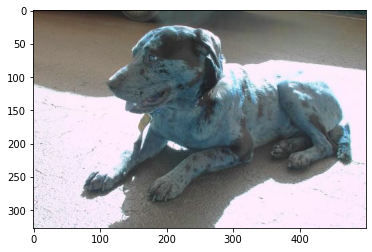

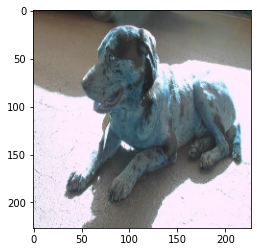

In [4]:
idx = 0
file_path = valid_file_paths[idx]
print(file_path)
image = cv2.imread(file_path)
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (227,227))
plt.imshow(resized_image)
plt.show()

### 載入模型

```
參數名稱       型態    說明
input_shape : tuple : 輸入影像形狀
classes_num : int   : 輸出類別數量
```

In [5]:
cnn = AlexNet(classes_num=2)
cnn.summary()

Model: "AlexNet"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image (InputLayer)                                    [(None, 227, 227, 3)]                           0                 
________________________________________________________________________________________________________________________
conv2d (Conv2D)                                       (None, 55, 55, 96)                              34944             
________________________________________________________________________________________________________________________
batch_normalization (BatchNormalization)              (None, 55, 55, 96)                              384               
________________________________________________________________________________________________________________________
re_lu (ReLU)   

### 配置訓練參數

```
參數名稱      型態                         說明
logdir     : str                        : 儲存路徑
epochs     : int                        : 訓練次數
batch_size : int                        : 批次大小 (註:此設定需與image_dataset_from_directory的批次大小一致)
optimizer  : str or tf.keras.optimizers : 優化函數
loss       : str or tf.keras.loss       : 損失函數
metrics    : list                       : 評估函數清單
```

In [6]:
cnn.setup_training(
    'log_alexnet',
    epochs=20,
    batch_size=50,  # batch size depend on ImageGenerator
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn.add_callback(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, patience=10,
        min_lr=0.00001,
        verbose=1
    )
)

******************************
Training new model...
******************************
checkpoint_path : log_alexnet\weights
best_checkpoint : log_alexnet\weights.h5
epochs          : 20
initial_epoch   : 0
batch_size      : 50
optimizer       : <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x000002AC46FB3A48>
loss            : categorical_crossentropy
metrics         : ['accuracy']


### 開始訓練

輸入參數分別為訓練資料集、驗證資料集的實例

In [7]:
cnn.train_dataset(train_dataset, valid_dataset)

Epoch 1/20
384/384 [==============================] - 103s 257ms/step - loss: 1.6785 - accuracy: 0.5115 - val_loss: 0.6871 - val_accuracy: 0.5458

Epoch 00001: val_loss improved from inf to 0.68710, saving model to log_alexnet\weights.h5
Epoch 2/20
384/384 [==============================] - 102s 263ms/step - loss: 0.6934 - accuracy: 0.5476 - val_loss: 0.6818 - val_accuracy: 0.5604

Epoch 00002: val_loss improved from 0.68710 to 0.68175, saving model to log_alexnet\weights.h5
Epoch 3/20
384/384 [==============================] - 102s 263ms/step - loss: 0.6854 - accuracy: 0.5518 - val_loss: 0.6784 - val_accuracy: 0.5617

Epoch 00003: val_loss improved from 0.68175 to 0.67839, saving model to log_alexnet\weights.h5
Epoch 4/20
384/384 [==============================] - 108s 279ms/step - loss: 0.6809 - accuracy: 0.5643 - val_loss: 0.6500 - val_accuracy: 0.6283

Epoch 00004: val_loss improved from 0.67839 to 0.64996, saving model to log_alexnet\weights.h5
Epoch 5/20
384/384 [================

### 繪製訓練過程曲線

可以用來確認權重是否有收斂的趨勢、檢查是否有過擬合狀況

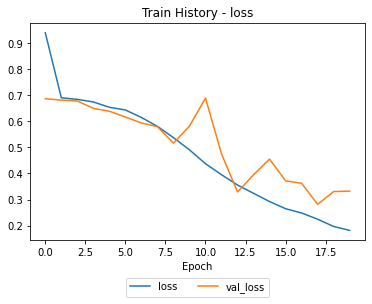

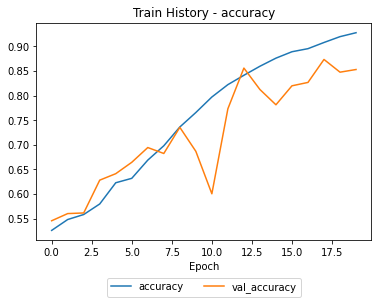

In [8]:
cnn.show_history(["loss", "accuracy"])

### 使用測試資料來確認模型對於新資料的效能

In [9]:
cnn.eval_dataset(valid_dataset)

96/96 [==============================] - 18s 179ms/step - loss: 0.3324 - accuracy: 0.8531


[0.33238762617111206, 0.8531249761581421]

### 使用confusion matrix來更進一步確認分類性能

- 預測測試資料的分數 (基於softmax函數計算機率分布)
- 使用`argmax`將分數轉成類別ID
- 輸出分類報告 (印出confusion matrix、分類報告；輸出完整報表)
- 繪製confusion matrix，分為recall、precision

> Note:  
recall: 召回率，在所有GT中，真正預測出TP的指標  
precision: 精確率，在所有預測結果中，真正為TP的指標  
(GT: 真實情況；TP: 正樣本)

Found 24000 files belonging to 2 classes.
Using 4800 files for validation.


100%|██████████| 4800/4800 [00:00<00:00, 252497.80it/s]


[[2201  194]
 [ 511 1894]] 

              precision    recall  f1-score   support

        Cats       0.81      0.92      0.86      2395
        Dogs       0.91      0.79      0.84      2405

    accuracy                           0.85      4800
   macro avg       0.86      0.85      0.85      4800
weighted avg       0.86      0.85      0.85      4800
 



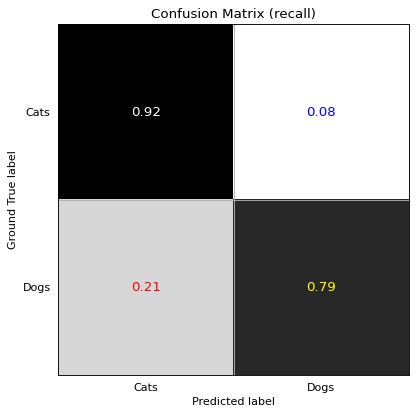

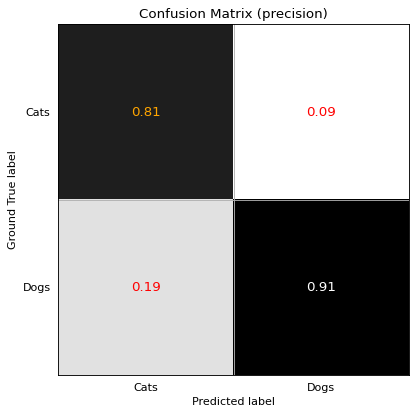

In [10]:
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/DogsVsCats/train',
    image_size=(227,227),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
pred_dataset = pred_dataset.map(lambda x, y: (x/255., y))

pr_score = None
pr_label = None
gt_label = None
for ind, batch_set in enumerate(pred_dataset):
    batch_im, batch_gt = batch_set
    batch_pr = cnn.pred(batch_im.numpy())
    if ind == 0:
        pr_score = batch_pr
        pr_label = batch_pr.argmax(axis=-1)
        gt_label = batch_gt.numpy().argmax(axis=-1)
    else:
        pr_score = np.concatenate([pr_score, batch_pr])
        pr_label = np.concatenate([pr_label, batch_pr.argmax(axis=-1)])
        gt_label = np.concatenate([gt_label, batch_gt.numpy().argmax(axis=-1)])

target_names = ["Cats", "Dogs"]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=cnn.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, cnn.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, cnn.logdir, title='Confusion Matrix (precision)')

### 預測單筆資料

./datasets/DogsVsCats/train\Dogs\6534.jpg


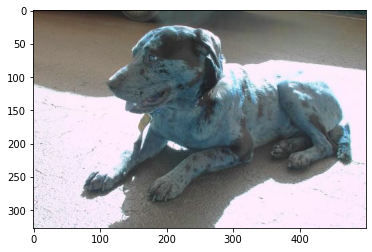

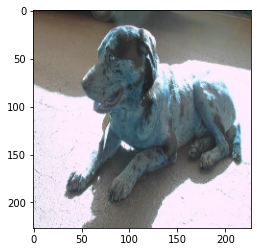

(1, 227, 227, 3, 1)

[Info] Use `tf.keras.Model` method predict

Score:
[1. 0.]
Label: 0


In [12]:
idx = 0

file_path = valid_file_paths[idx]
print(file_path)
image = cv2.imread(file_path)
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (227,227))
plt.imshow(resized_image)
plt.show()

batch_one_image = np.expand_dims(resized_image, axis=0)
batch_one_image = np.expand_dims(batch_one_image, axis=-1)
print(batch_one_image.shape)

pr_sc = cnn.predict(batch_one_image)
pr_lb = pr_sc.argmax(axis=-1)
print("Score:")
print(pr_sc[0])
print("Label:", pr_lb[0])